# CIFAR10 Dataset

In [1]:
# My neural net model
from neural_net import neural_net
from vis_utils import plotStats, plotData
from gradient_utils import gradient_difference
from tuning_utils import tuning_hyper_parameter
from vis_utils import visualize_grid_withoutRGB, visualize_grid

# Linear algebra library
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 5) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
from vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.function_params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()


In [3]:
def plot_image(i, predictions_array, true_label, img):
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 
               'frog', 'horse', 'ship', 'truck']
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img.astype('uint8'))

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(classes[predicted_label],
                                         100*np.max(predictions_array),true_label),
                                           color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

## Loading dataset

In [4]:
from features import color_histogram_hsv, hog_feature
from data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'data/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    mean_image = np.mean(X_train, axis=0)
    
    return X_train, y_train, X_val, y_val, X_test, y_test, mean_image

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test, mean_image = get_CIFAR10_data()
print('Finish Loading Datasets')

Finish Loading Datasets


In [5]:
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


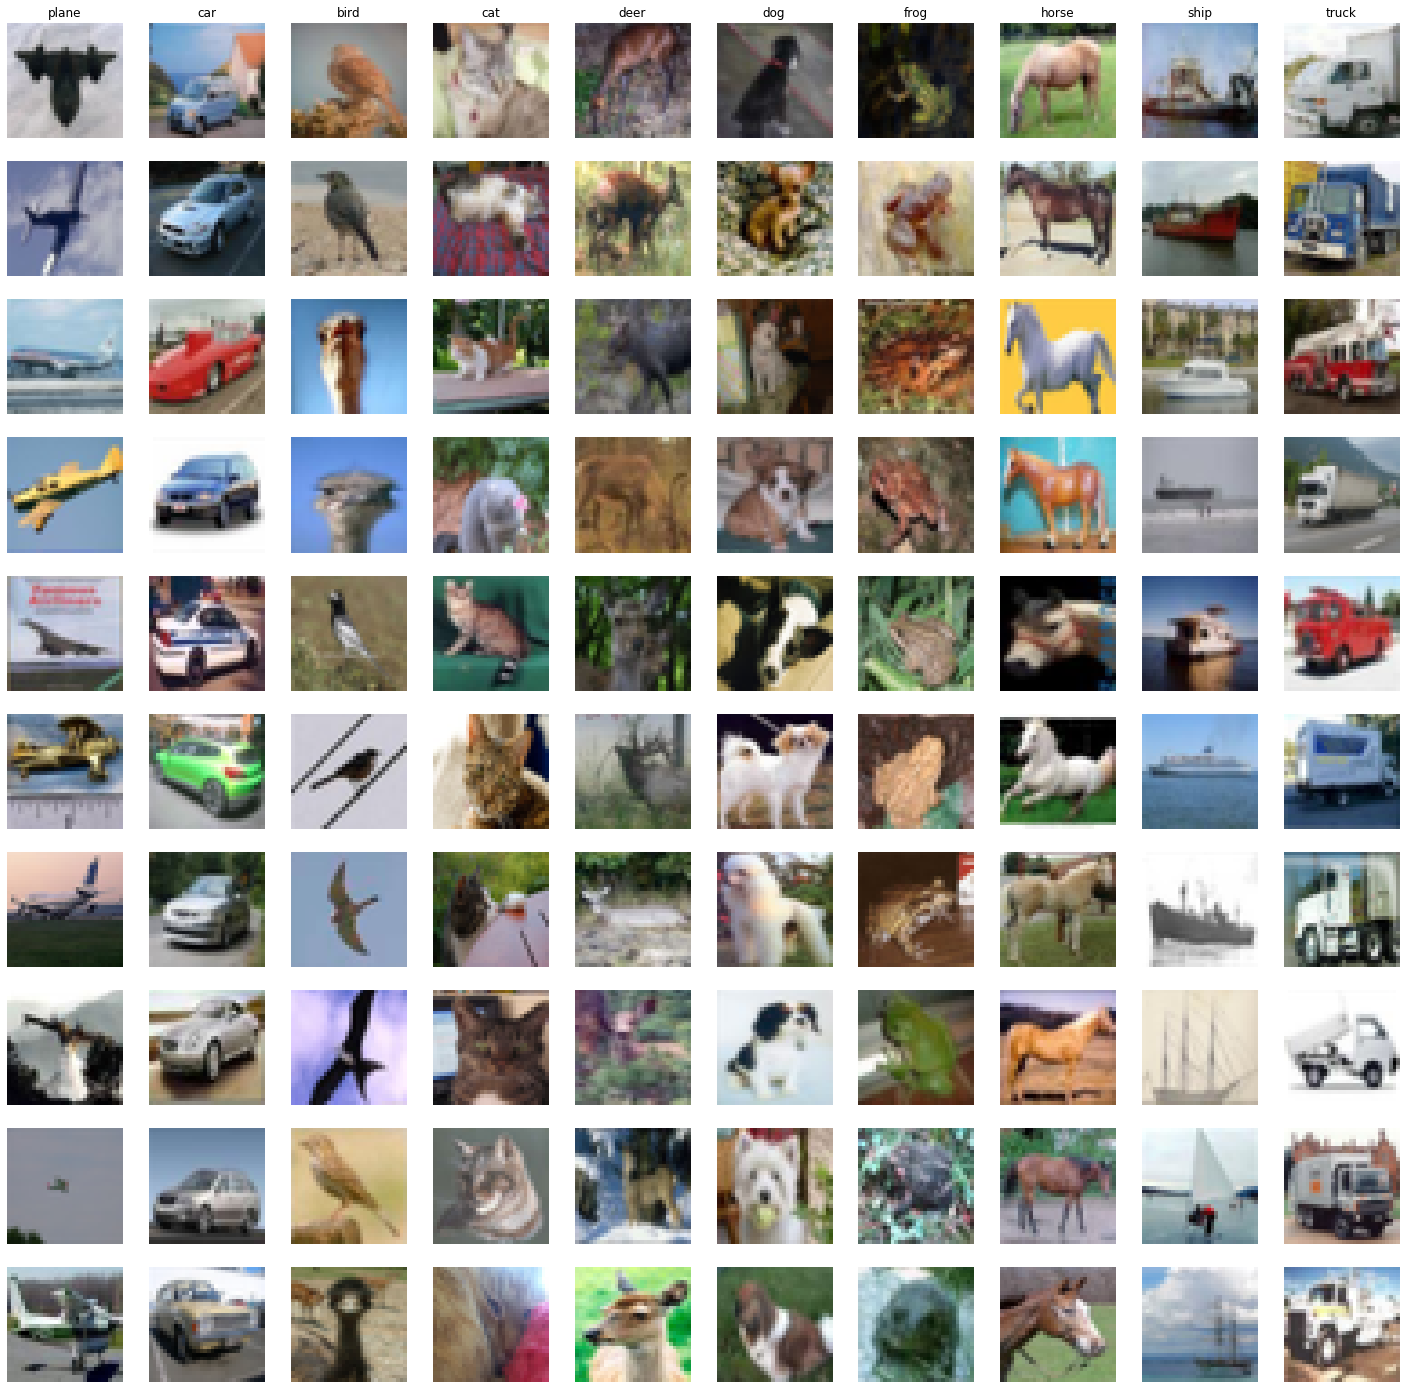

In [6]:
plt.rcParams['figure.figsize'] = (25, 25) # set default size of plots
#plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
examples_per_class = 10
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 
           'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

## Process Images

In [7]:
from features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns, verbose = True)
X_test_feats = extract_features(X_test, feature_fns, verbose = True)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

In [8]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(f'train data feats shape {X_train_feats.shape}')
print(f'val data feats shape {X_val_feats.shape}')
print(f'test data feats shape {X_test_feats.shape}')

(49000, 155)
train data feats shape (49000, 154)
val data feats shape (1000, 154)
test data feats shape (1000, 154)


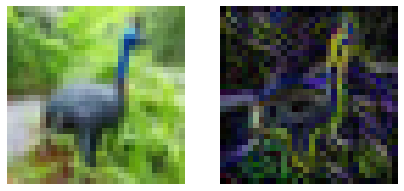

In [10]:
import cv2
plt.rcParams['figure.figsize'] = (7, 7)
img = np.float32(X_train[6])/255
 
# Calculate gradient 
gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis('off')
plt.subplot(1,2,2)
mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
plt.imshow(mag)
plt.axis('off')
plt.show()

## Train a model in preprocessing Images

In [11]:
# net_params = {'il':X_train_feats.shape[1],'hl1':416,'hl2':416,'ol':10}
net_params = {'il':X_train_feats.shape[1],'hl1':50,'ol':10}

# activ_function = 'Sigmoid'
# cost_function = 'Entropy_Loss'
activ_function = 'ReLu'
cost_function = 'SoftMax'
net = neural_net(net_params, activ_function, cost_function, std = 1e-4)

# results = net.train_sgd_momentum(X_train_feats, y_train, X_val_feats, y_val, 
#                                  learning_rate=2.590628e-01, reg = 4.789351e-07,
#                                  max_iter = 5000, batch_size = 200, 
#                                  verbose =  True, rho = 0.50, stochastic = True, 
#                                  epoch = 50)

results = net.train_sgd_momentum(X_train_feats, y_train, X_val_feats, y_val, 
                                 learning_rate=2.590628e-01, reg = 4.789351e-07,
                                 max_iter = 5000, batch_size = 200, 
                                 verbose =  True, rho = 0.50, stochastic = True, 
                                 epoch = 50)

## Show results

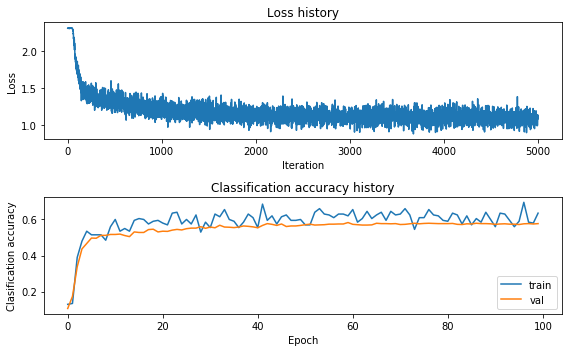

accuracy in training set : 61.067346938775515
accuracy in validation set : 57.599999999999994
accuracy in validation set : 56.89999999999999


In [12]:
plotStats(results)
y_pred, train_score = net.predict(X_train_feats, with_score=True)
print(f'accuracy in training set : {(y_pred == y_train).mean() *100}')
y_pred_val, val_score = net.predict(X_val_feats, with_score=True)
print(f'accuracy in validation set : {(y_pred_val == y_val).mean() *100}')
y_pred_test, test_score = net.predict(X_test_feats, with_score=True)
print(f'accuracy in validation set : {(y_pred_test == y_test).mean() *100}')

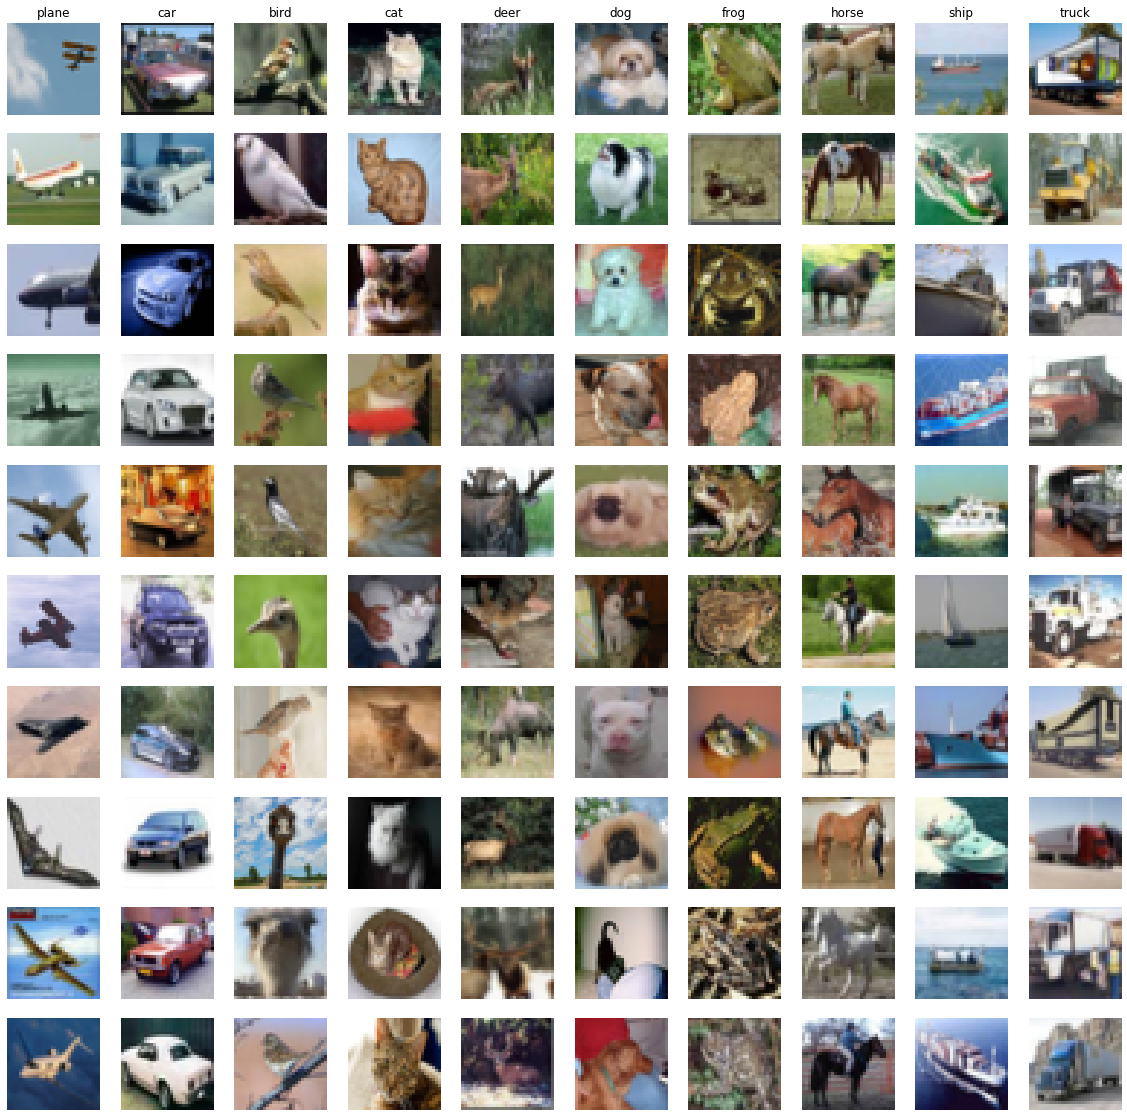

In [13]:
plt.rcParams['figure.figsize'] = (20, 20) # set default size of plots
#plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
examples_per_class = 10
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test == cls) & (y_pred_test == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

In [14]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 
               'frog', 'horse', 'ship', 'truck']
stri = ''
for i, clas in enumerate(classes):
    stri = stri+','+str(i)+': '+clas
print(stri)

,0: plane,1: car,2: bird,3: cat,4: deer,5: dog,6: frog,7: horse,8: ship,9: truck


,0: plane,1: car,2: bird,3: cat,4: deer,5: dog,6: frog,7: horse,8: ship,9: truck


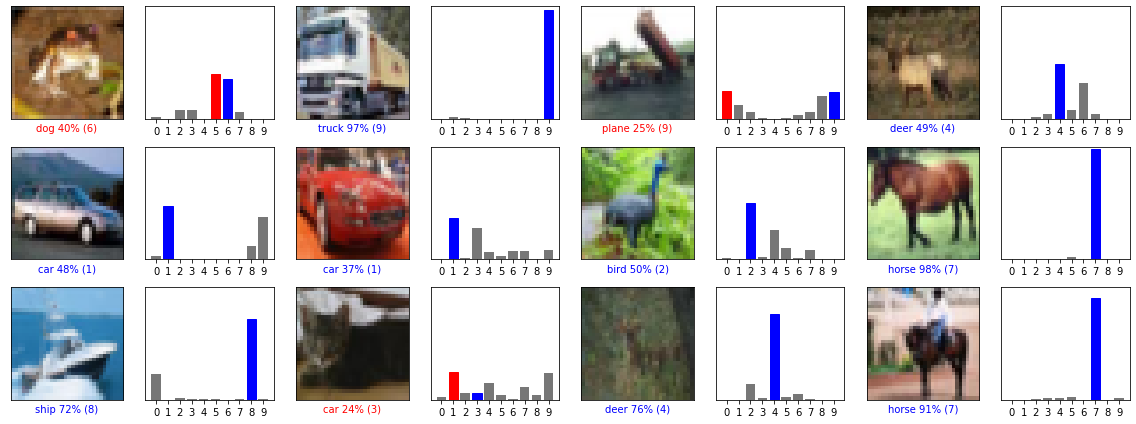

In [15]:
print(stri)
num_rows = 3
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, train_score[i], y_train, X_train)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, train_score[i], y_train)
plt.tight_layout()
plt.show()

## Work in raw Images

In [18]:
from data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):

    # Load the raw CIFAR-10 data
    cifar10_dir = 'data/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test, mean_image


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    del X, y
    print('Clear previously loaded data.')
except:
    pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, mean_image = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Finisth Loading Images')

In [20]:
net_params = {'il':X_train.shape[1],'hl1':50,'ol':10}
# activ_function = 'Sigmoid'
# cost_function = 'Entropy_Loss'
activ_function = 'ReLu'
cost_function = 'SoftMax'
net = neural_net(net_params, activ_function, cost_function, std = 1e-4)

# results = net.train_stochastic_gradient_descent(X_train, y_train, X_val, y_val, 
#                                         learning_rate=3.9e-04, reg = 4.789351e-04,
#                                  max_iter = 10000, batch_size = 200, verbose =  True, 
#                                                 epoch = 500)
results = net.train_stochastic_gradient_descent(X_train, y_train, X_val, y_val, 
                                        learning_rate=2.0e-04, reg = 4.789351e-04,
                                 max_iter = 2000, batch_size = 200, verbose =  True, 
                                                epoch = 500)

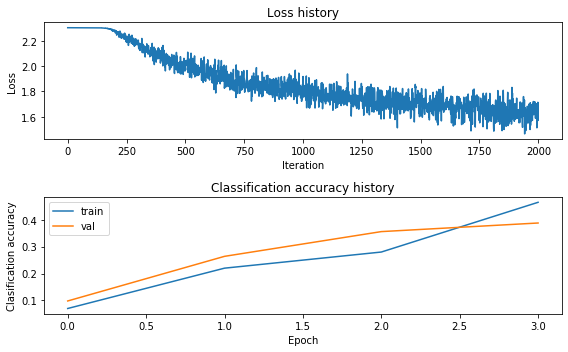

accuracy in training set : 42.012244897959185
accuracy in validation set : 42.5
accuracy in validation set : 41.0


In [21]:
plotStats(results)
y_pred, train_score = net.predict(X_train, with_score=True)
print(f'accuracy in training set : {(y_pred == y_train).mean() *100}')
y_pred_val, val_score = net.predict(X_val, with_score=True)
print(f'accuracy in validation set : {(y_pred_val == y_val).mean() *100}')
y_pred_test, test_score = net.predict(X_test, with_score=True)
print(f'accuracy in validation set : {(y_pred_test == y_test).mean() *100}')

In [22]:
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3) + mean_image

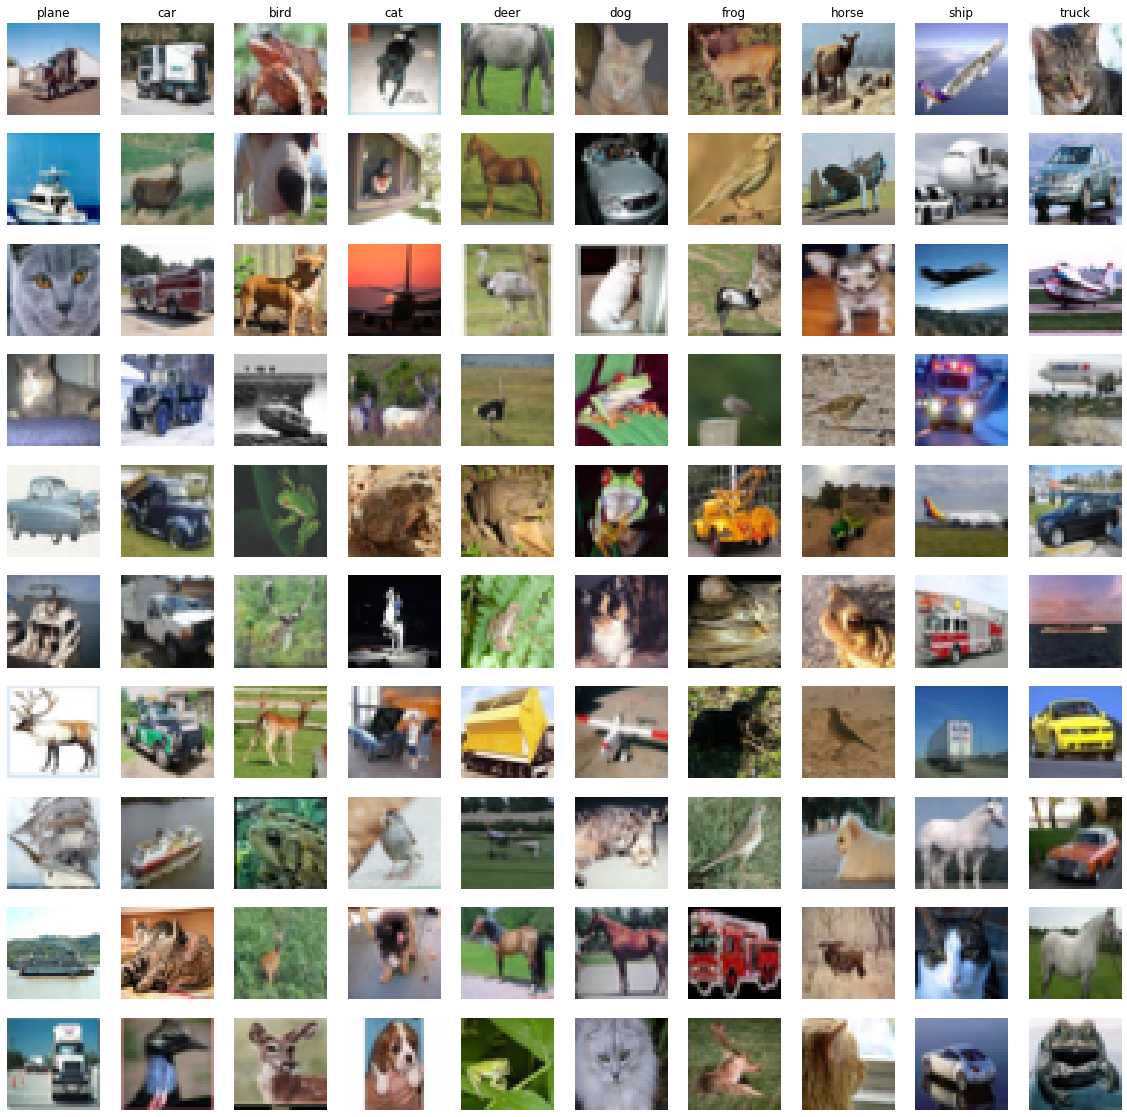

In [23]:
plt.rcParams['figure.figsize'] = (20, 20) # set default size of plots
#plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
examples_per_class = 10
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_train != cls) & (y_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

,0: plane,1: car,2: bird,3: cat,4: deer,5: dog,6: frog,7: horse,8: ship,9: truck


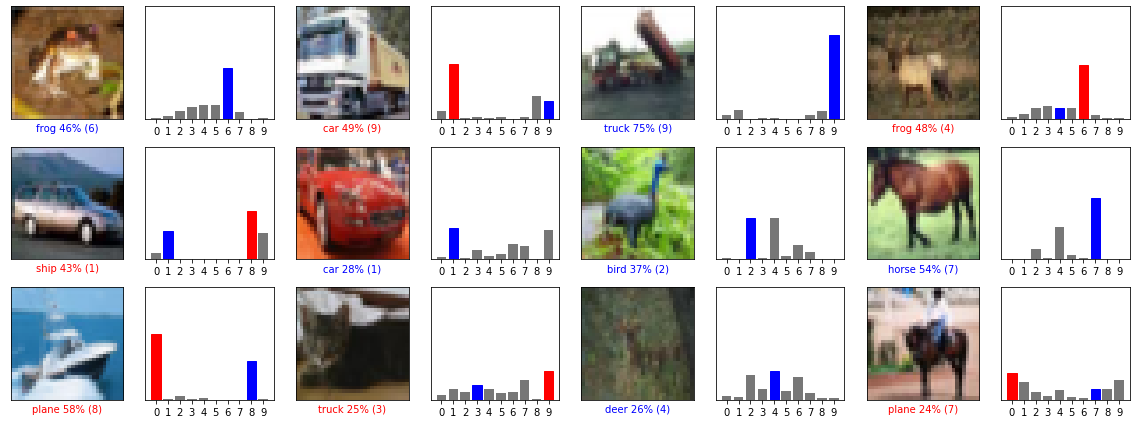

In [24]:
print(stri)
num_rows = 3
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, train_score[i], y_train, X_train)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, train_score[i], y_train)
plt.tight_layout()
plt.show()

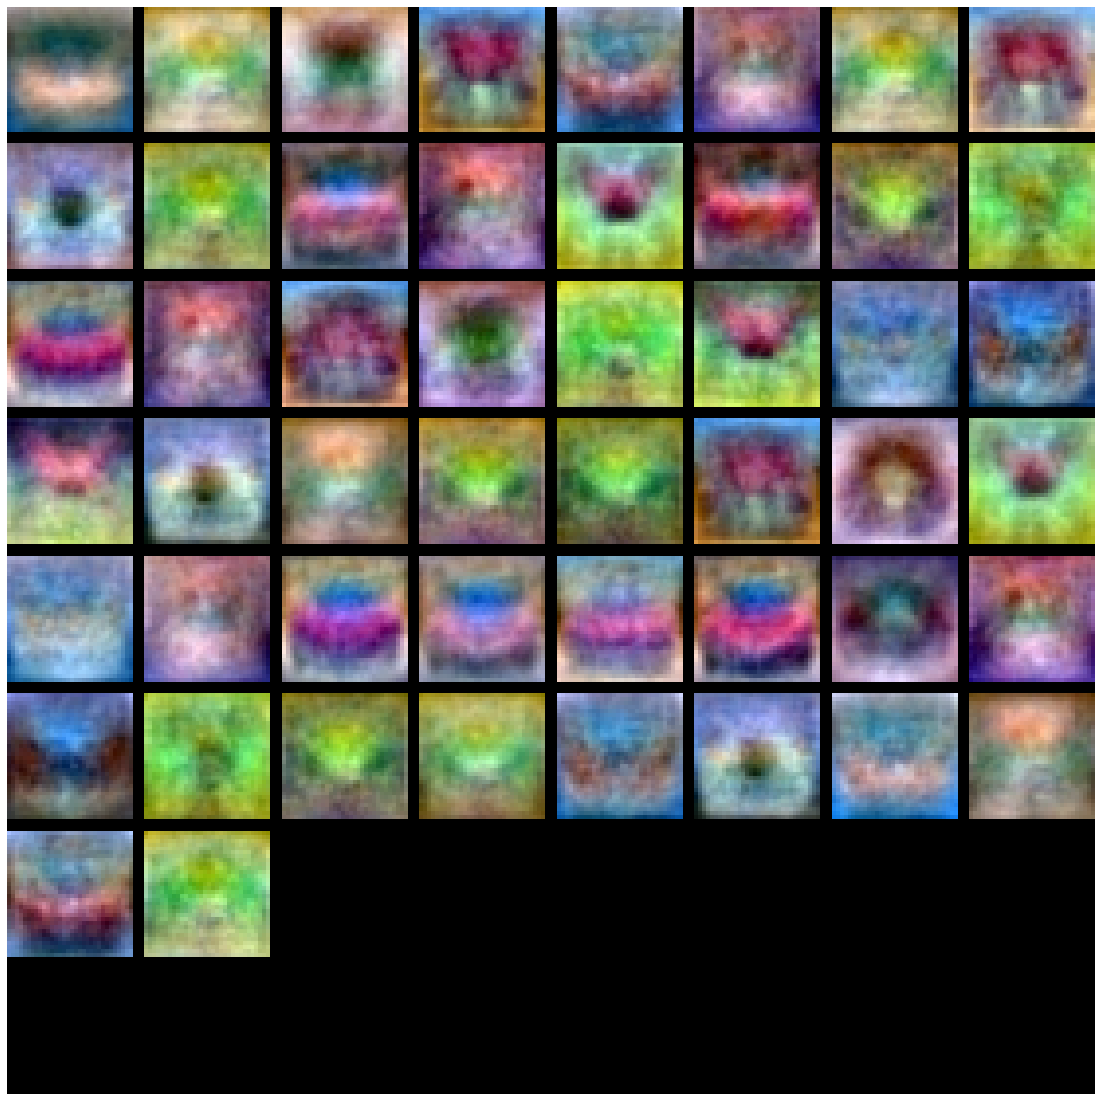

In [25]:
show_net_weights(net)

# State of the art tech

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [3]:
train_images, test_images = train_images / 255.0, test_images / 255.0

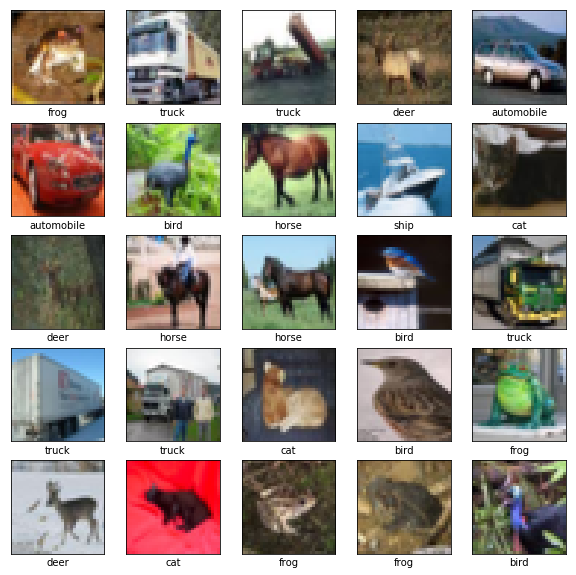

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [5]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

In [9]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
len(model.get_weights())

10

In [11]:
weights_history = []

# A custom callback
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback
class MyCallback(keras.callbacks.Callback):
    def on_batch_end(self, batch, logs):
        weights_history.append(model.get_weights())


callback = MyCallback()

In [12]:
history = model.fit(train_images, train_labels, epochs=1, 
                    validation_data=(test_images, test_labels), callbacks=[callback])

Train on 50000 samples, validate on 10000 samples
50000/50000 [==============================] - 53s 1ms/sample - loss: 1.5253 - acc: 0.4416 - val_loss: 1.2939 - val_acc: 0.5323


10000/10000 - 2s - loss: 1.2939 - acc: 0.5323


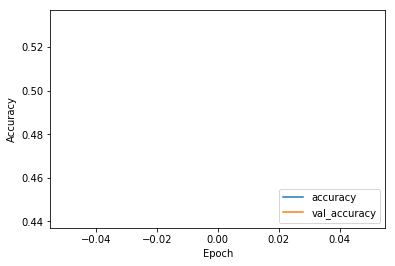

In [14]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)